<a href="https://colab.research.google.com/github/prarthana127/Parameter-Optimization-SVM/blob/main/Parameter_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('/content/online_shoppers_intention.csv')

In [22]:
df.dropna(inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop('Revenue', axis=1)
y = df['Revenue']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y.to_numpy().ravel(), test_size=0.3, random_state=42
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Define kernel options
kernels = ['rbf', 'poly', 'linear']
pbounds = {
    'kernel': (0, len(kernels) - 1),
    'nu': (0.01, 0.2),
    'tol': (1e-6, 1.0)
}


In [25]:
# Evaluation function
def evaluate_svm(kernel, nu, tol):
    kernel_name = kernels[int(kernel)]
    model = NuSVC(kernel=kernel_name, nu=nu, tol=tol)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run optimization for 10 samples
results = []
optimizers = []
targets = []
iteration_counts = []

for sample in range(10):
    optimizer = BayesianOptimization(
        f=evaluate_svm,
        pbounds=pbounds,
        random_state=sample
    )
    optimizer.maximize(init_points=5, n_iter=100)

    best_params = optimizer.max['params']
    best_accuracy = optimizer.max['target']
    results.append((sample, best_accuracy, best_params))
    optimizers.append(optimizer)

    targets.append(optimizer._space.target)
    iteration_counts.append(optimizer._space.params.shape[0])


|   iter    |  target   |  kernel   |    nu     |    tol    |
-------------------------------------------------------------
| 1         | 0.871     | 1.098     | 0.1459    | 0.6028    |
| 2         | 0.5237    | 1.09      | 0.09049   | 0.6459    |
| 3         | 0.84      | 0.8752    | 0.1794    | 0.9637    |
| 4         | 0.8667    | 0.7669    | 0.1604    | 0.5289    |
| 5         | 0.8802    | 1.136     | 0.1859    | 0.07104   |
| 6         | 0.8551    | 1.338     | 0.145     | 0.8464    |
| 7         | 0.887     | 0.4606    | 0.1919    | 0.3832    |
| 8         | 0.717     | 1.082     | 0.1151    | 0.7326    |
| 9         | 0.7343    | 0.3907    | 0.06233   | 0.08634   |
| 10        | 0.7105    | 0.7441    | 0.03194   | 0.8571    |
| 11        | 0.867     | 1.813     | 0.1444    | 0.2393    |
| 12        | 0.8681    | 1.966     | 0.1323    | 0.864     |
| 13        | 0.8408    | 0.4121    | 0.0444    | 0.0003741 |
| 14        | 0.3955    | 1.644     | 0.03294   | 0.4002    |
| 15    

In [27]:
table = pd.DataFrame(results, columns=['Sample', 'Best Accuracy', 'Best SVM Parameter'])
print(table)

   Sample  Best Accuracy                                 Best SVM Parameter
0       0       0.893214  {'kernel': 0.6793841394400977, 'nu': 0.1924314...
1       1       0.894025  {'kernel': 0.6614377612963924, 'nu': 0.1949005...
2       2       0.893214  {'kernel': 0.990902982355826, 'nu': 0.19667937...
3       3       0.893755  {'kernel': 0.04747169048358302, 'nu': 0.197726...
4       4       0.892944  {'kernel': 0.013451343050175701, 'nu': 0.18667...
5       5       0.892674  {'kernel': 0.6788578048898288, 'nu': 0.1940195...
6       6       0.892674  {'kernel': 0.8297471676479156, 'nu': 0.1908612...
7       7       0.892403  {'kernel': 0.9576509637715571, 'nu': 0.1928587...
8       8       0.885915  {'kernel': 0.03373365027443276, 'nu': 0.199209...
9       9       0.892944  {'kernel': 0.6743820112708294, 'nu': 0.1926893...


In [29]:
max_idx = table['Best Accuracy'].idxmax()
max_accuracy_sample = table.iloc[max_idx]
print(f"Sample with maximum accuracy: {max_accuracy_sample['Sample']}")

Sample with maximum accuracy: 1


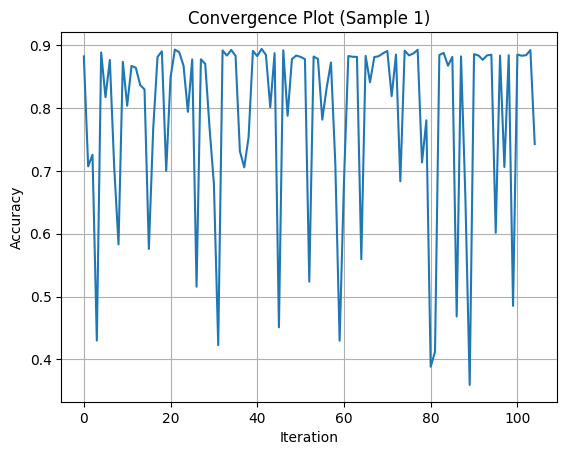

In [33]:
# Plot convergence of best sample
best_index = np.argmax([acc for _, acc, _ in results])
plt.plot(targets[best_index])
plt.title(f"Convergence Plot (Sample {best_index})")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()